In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_data = pd.read_parquet('/content/drive/MyDrive/ML_Project/combined/final_data.parquet')

In [ ]:
# Sort data to avoid look ahead bias
final_data = final_data.sort_values('date')

In [ ]:
final_data.shape

(610192, 30)

In [ ]:
final_data.columns

Index(['permno', 'cusip', 'industry', 'date', 'ret', 'ret_market',
       'ret_now_sign', 'ret_lag1', 'ret_trend1_sign', 'ret_cum_forward3m',
       'ret_cum_forward3m_sign', 'ret_cum_forward12m',
       'ret_cum_forward12m_sign', 'ret_cum_backward3m', 'ret_cum_backward6m',
       'ret_cum_backward12m', 'gvkey', 'datadate', 'capxy', 'chechy', 'cshfdy',
       'cshpry', 'dltry', 'dpcy', 'epspxy', 'oibdpy', 'txty', 'report_date',
       'transcriptid', 'embedding_vector'],
      dtype='object')

In [ ]:
final_data.isna().sum()

,0
permno,0
cusip,0
industry,0
date,0
ret,0
ret_market,0
ret_now_sign,2364
ret_lag1,0
ret_trend1_sign,403
ret_cum_forward3m,12112


# Multi Model DNN

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

## Predicting trend

In [ ]:
final_data_single = final_data.copy()

# CHANGE THIS VARIABLE TO DECIDE THE FORECAST WINDOW: 1 month: ret_trend1_sign, 3 months: 'ret_cum_forward3m_sign', 12 months: 'ret_cum_forward12m_sign'
current_target = 'ret_cum_forward12m_sign'

final_data_single = final_data_single.dropna(subset=[current_target])

In [ ]:
compustat_cols = ['oibdpy', 'capxy', 'chechy', 'cshfdy', 'cshpry', 'txty', 'epspxy', 'dltry', 'dpcy']
return_cols = ['ret_lag1', 'ret_cum_backward3m', 'ret_cum_backward6m', 'ret_cum_backward12m']

target_col = [current_target]

N_COMPUSTAT_FEATURES = len(compustat_cols)
N_RETURN_FEATURES = len(return_cols)
N_CLASSES = 1

X_compustat = final_data_single[compustat_cols]
X_returns = final_data_single[return_cols]
X_embeddings = np.stack(final_data_single['embedding_vector'].values)
y = final_data_single[target_col]

N_EMBEDDING_FEATURES = X_embeddings.shape[1]

In [ ]:
X_compustat.shape, X_returns.shape, X_embeddings.shape, y.shape

((544568, 9), (544568, 4), (544568, 768), (544568, 1))

In [ ]:
np.isnan(X_compustat).sum(), np.isnan(X_returns).sum(), np.isnan(X_embeddings).sum(), np.isnan(y).any()

(oibdpy    0
 capxy     0
 chechy    0
 cshfdy    0
 cshpry    0
 txty      0
 epspxy    0
 dltry     0
 dpcy      0
 dtype: int64,
 ret_lag1               0
 ret_cum_backward3m     0
 ret_cum_backward6m     0
 ret_cum_backward12m    0
 dtype: int64,
 np.int64(0),
 ret_cum_forward12m_sign    False
 dtype: bool)

In [ ]:
# Scale input
scaler_compustat = StandardScaler()
X_compustat_scaled = scaler_compustat.fit_transform(X_compustat)

scaler_returns = StandardScaler()
X_returns_scaled = scaler_returns.fit_transform(X_returns)

scaler_embeddings = StandardScaler()
X_embeddings_scaled = scaler_embeddings.fit_transform(X_embeddings)

# Convert to category variables, we are using relu at the end so 0 and 1
y_binary = y.replace(-1, 0)

In [ ]:
# Split data
train_size = int(len(final_data_single) * 0.7)
val_size = int(len(final_data_single) * 0.15)

X_compustat_train, X_returns_train, X_embeddings_train = X_compustat_scaled[:train_size], X_returns_scaled[:train_size], X_embeddings_scaled[:train_size]
X_compustat_val, X_returns_val, X_embeddings_val = X_compustat_scaled[train_size:train_size+val_size], X_returns_scaled[train_size:train_size+val_size], X_embeddings_scaled[train_size:train_size+val_size]
X_compustat_test, X_returns_test, X_embeddings_test = X_compustat_scaled[train_size+val_size:], X_returns_scaled[train_size+val_size:], X_embeddings_scaled[train_size+val_size:]

y_train, y_val, y_test = y_binary[:train_size], y_binary[train_size:train_size+val_size], y_binary[train_size+val_size:]

In [ ]:
np.unique(y_train)

array([0., 1.])

In [ ]:
def build_multi_input_model(n_embedding_features, use_compustat=True, use_returns=True, use_reports=True,):
    # Input A: Compustat Factors Branch
    input_compustat = Input(shape=(N_COMPUSTAT_FEATURES,), name='compustat_input')
    x1 = Dense(64, activation='relu')(input_compustat)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(32, activation='relu')(x1)

    # Input B: Cumulative Returns Branch

    # Simple Dense layer
    # input_returns = Input(shape=(N_RETURN_FEATURES,), name='returns_input')
    # x2 = Dense(32, activation='relu')(input_returns)
    # x2 = BatchNormalization()(x2)
    # x2 = Dropout(0.3)(x2)
    # x2 = Dense(16, activation='relu')(x2)

    input_returns = Input(shape=(N_RETURN_FEATURES, 1), name='returns_input')
    # 1D Convolutional layer to find temporal patterns
    x2 = Conv1D(filters=32, kernel_size=2, activation='relu')(input_returns)
    x2 = GlobalMaxPooling1D()(x2)
    x2 = Dropout(0.3)(x2)

    # Input C: Textual Embeddings Branch
    input_embeddings = Input(shape=(n_embedding_features,), name='embedding_input')
    x3 = Dense(128, activation='relu')(input_embeddings)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.5)(x3)
    x3 = Dense(64, activation='relu')(x3)

    # Concatenate the outputs of the three branches
    if use_compustat and use_returns and use_reports:
        combined = Concatenate()([x1, x2, x3])
    elif use_compustat and use_returns:
        combined = Concatenate()([x1, x2])
    elif use_compustat and use_reports:
        combined = Concatenate()([x1, x3])
    elif use_returns and use_reports:
        combined = Concatenate()([x2, x3])
    elif use_compustat:
        combined = x1
    elif use_returns:
        combined = x2
    elif use_reports:
        combined = x3

    # Final prediction head
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(32, activation='relu')(z)

    # Output layer for binary classification
    output_layer = Dense(N_CLASSES, activation='sigmoid', name='output')(z)

    # Build and compile the model
    model = Model(inputs=[input_compustat, input_returns, input_embeddings], outputs=output_layer)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_multi_input_model(N_EMBEDDING_FEATURES, True, True, True)
model.summary()

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

all_possible_classes = np.array([0, 1])

# Balance the training dataset
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = all_possible_classes,
    y = np.ravel(y_train)
)

class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

history = model.fit(
    [X_compustat_train, X_returns_train, X_embeddings_train],
    y_train,
    validation_data=([X_compustat_val, X_returns_val, X_embeddings_val], y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ compustat_input     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_input     │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        640 │ compustat_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_input       │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     98,432 │ embedding_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3, 32)     │         96 │ returns_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dropout_9[0][0],  │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,257 (469.75 KB)

 Non-trainable params: 384 (1.50 KB)

{0: np.float64(1.1920452555474945), 1: np.float64(0.8612480513318723)}
Epoch 1/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.5653 - loss: 0.6793 - val_accuracy: 0.4312 - val_loss: 0.7740
Epoch 2/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6220 - loss: 0.6429 - val_accuracy: 0.4283 - val_loss: 0.8015
Epoch 3/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6352 - loss: 0.6313 - val_accuracy: 0.4364 - val_loss: 0.8082
Epoch 4/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6487 - loss: 0.6206 - val_accuracy: 0.4382 - val_loss: 0.8040
Epoch 5/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6554 - loss: 0.6122 - val_accuracy: 0.4418 - val_loss: 0.7776
Epoch 6/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6640 - loss: 0.6048 - val_accuracy: 0.4458 - val_loss: 0.7593
Epoch 7/50
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6697 - loss: 0.5988 - val_accuracy: 0.4481 - val_loss: 0.7840
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(
    [X_compustat_test, X_returns_test, X_embeddings_test],
    y_test
)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2553/2553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5413 - loss: 0.7008

Test Accuracy: 0.5018
Test Loss: 0.7251



Plotting training and validation history...


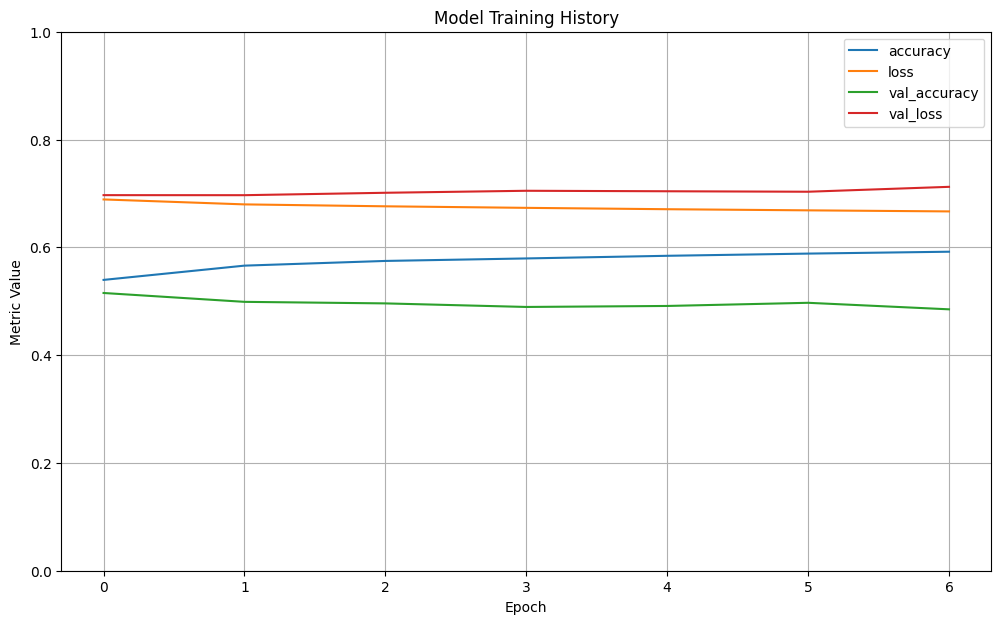

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(12, 7))
plt.grid(True)
plt.title('Model Training History')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
predicted_probabilities = model.predict(
    [X_compustat_test, X_returns_test, X_embeddings_test]
)
predicted_classes = (predicted_probabilities > 0.5).astype(int)

y_test_series = y_test[current_target].reset_index(drop=True)

results_df = pd.DataFrame({
    'True_Label': y_test_series,
    'Predicted_Probability': predicted_probabilities.flatten(),
    'Predicted_Class': predicted_classes.flatten()
})

print("\nSample of Predictions vs. True Labels:")
print(results_df.head(15))

from sklearn.metrics import classification_report

print("\nClassification Report on Test Set:")
print(classification_report(results_df['True_Label'], results_df['Predicted_Class'], target_names=['Decrease (0)', 'Increase (1)']))

2553/2553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Sample of Predictions vs. True Labels:
    True_Label  Predicted_Probability  Predicted_Class
0          0.0               0.298316                0
1          0.0               0.472865                0
2          0.0               0.536379                1
3          0.0               0.393080                0
4          1.0               0.342113                0
5          1.0               0.397319                0
6          0.0               0.401381                0
7          0.0               0.514535                1
8          0.0               0.523461                1
9          0.0               0.419428                0
10         0.0               0.194522                0
11         0.0               0.484845                0
12         0.0               0.533679                1
13         1.0               0.551281                1
14         1.0               0.315218                0

Classification Report on Test Set:
 

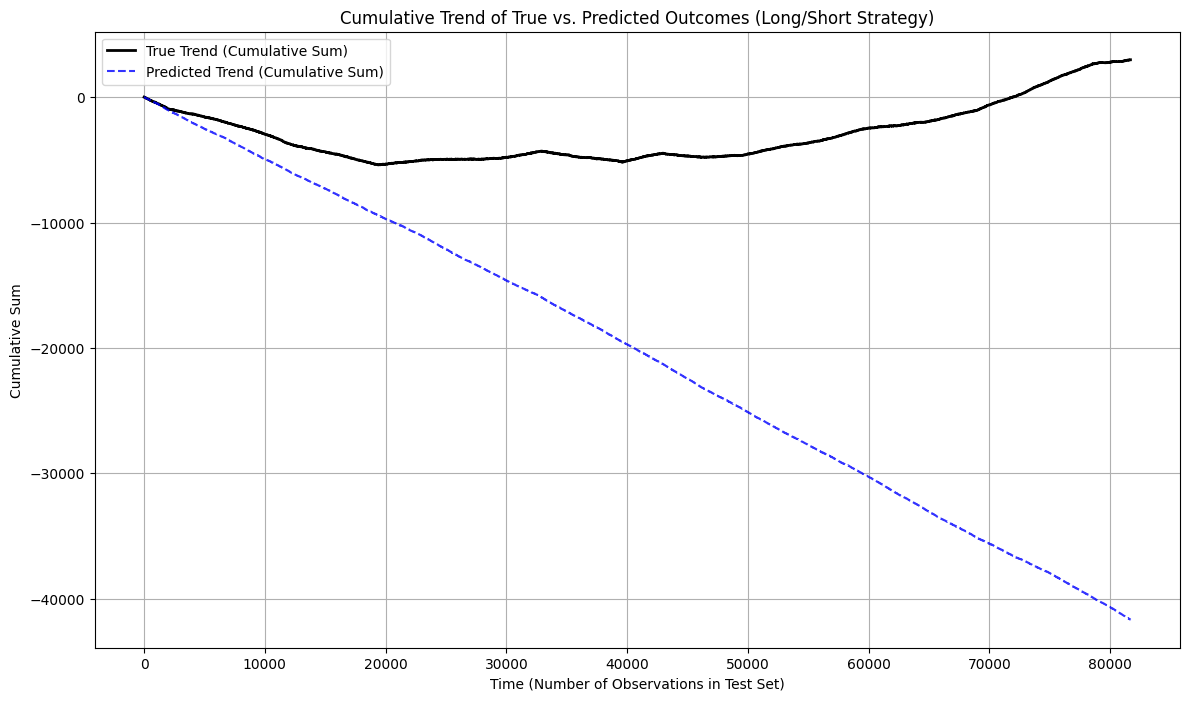

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Map 0s to -1 to represent betting against a "decrease" signal
y_true_long_short = results_df['True_Label'].replace(0, -1)
y_pred_long_short = results_df['Predicted_Class'].replace(0, -1)

true_trend = y_true_long_short.cumsum()
pred_trend = y_pred_long_short.cumsum()

plt.figure(figsize=(14, 8))
plt.plot(true_trend, label='True Trend (Cumulative Sum)', linestyle='-', color='black', linewidth=2)
plt.plot(pred_trend, label='Predicted Trend (Cumulative Sum)', linestyle='--', color='blue', alpha=0.8)

plt.title('Cumulative Trend of True vs. Predicted Outcomes (Long/Short Strategy)')
plt.xlabel('Time (Number of Observations in Test Set)')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.show()

# Multi input model with actual single period return data

In [ ]:
final_data_actual_single = final_data.copy()
final_data_actual_single = final_data_actual_single.dropna(subset=['ret'])

In [ ]:
compustat_cols = ['oibdpy', 'capxy', 'chechy', 'cshfdy', 'cshpry', 'txty', 'epspxy', 'dltry', 'dpcy']
return_cols = ['ret_lag1', 'ret_cum_backward3m', 'ret_cum_backward6m', 'ret_cum_backward12m']

target_col = ['ret']

N_COMPUSTAT_FEATURES = len(compustat_cols)
N_RETURN_FEATURES = len(return_cols)
N_CLASSES = 1

X_compustat = final_data_actual_single[compustat_cols]
X_returns = final_data_actual_single[return_cols]
X_embeddings = np.stack(final_data_actual_single['embedding_vector'].values)
y_regression = final_data_actual_single[target_col]

N_EMBEDDING_FEATURES = X_embeddings.shape[1]

In [ ]:
# Scale input
scaler_compustat = StandardScaler()
X_compustat_scaled = scaler_compustat.fit_transform(X_compustat)

scaler_returns = StandardScaler()
X_returns_scaled = scaler_returns.fit_transform(X_returns)

scaler_embeddings = StandardScaler()
X_embeddings_scaled = scaler_embeddings.fit_transform(X_embeddings)

In [ ]:
# Split data
train_size = int(len(final_data) * 0.7)
val_size = int(len(final_data) * 0.15)

X_compustat_train, X_returns_train, X_embeddings_train = X_compustat_scaled[:train_size], X_returns_scaled[:train_size], X_embeddings_scaled[:train_size]
X_compustat_val, X_returns_val, X_embeddings_val = X_compustat_scaled[train_size:train_size+val_size], X_returns_scaled[train_size:train_size+val_size], X_embeddings_scaled[train_size:train_size+val_size]
X_compustat_test, X_returns_test, X_embeddings_test = X_compustat_scaled[train_size+val_size:], X_returns_scaled[train_size+val_size:], X_embeddings_scaled[train_size+val_size:]

y_train, y_val, y_test = y_regression.iloc[:train_size], y_regression.iloc[train_size:train_size+val_size], y_regression.iloc[train_size+val_size:]

In [ ]:
def build_multi_input_model_regression(n_embedding_features):
    """Builds the Keras multi-input functional model for regression."""

    # Input branches are identical to the classification model
    input_compustat = Input(shape=(N_COMPUSTAT_FEATURES,), name='compustat_input')
    x1 = Dense(64, activation='relu')(input_compustat)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(32, activation='relu')(x1)

    input_returns = Input(shape=(N_RETURN_FEATURES,), name='returns_input')
    x2 = Dense(32, activation='relu')(input_returns)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(16, activation='relu')(x2)

    input_embeddings = Input(shape=(n_embedding_features,), name='embedding_input')
    x3 = Dense(128, activation='relu')(input_embeddings)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(0.5)(x3)
    x3 = Dense(64, activation='relu')(x3)

    combined = Concatenate()([x1, x2, x3])

    # Final prediction head
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(32, activation='relu')(z)

    output_layer = Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[input_compustat, input_returns, input_embeddings], outputs=output_layer)

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae', 'mse'])

    return model

In [ ]:
model = build_multi_input_model_regression(N_EMBEDDING_FEATURES)
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    [X_compustat_train, X_returns_train, X_embeddings_train], y_train,
    validation_data=([X_compustat_val, X_returns_val, X_embeddings_val], y_val),
    epochs=100, batch_size=256, callbacks=[early_stopping]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ compustat_input     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_input     │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        640 │ compustat_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        160 │ returns_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     98,432 │ embedding_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 112)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_11[0][0],   │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      7,232 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,337 (470.07 KB)

 Trainable params: 119,889 (468.32 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0625 - mae: 0.1423 - mse: 0.0625 - val_loss: 0.0374 - val_mae: 0.1121 - val_mse: 0.0374
Epoch 2/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0225 - mae: 0.0922 - mse: 0.0225 - val_loss: 0.0374 - val_mae: 0.1122 - val_mse: 0.0374
Epoch 3/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0222 - mae: 0.0920 - mse: 0.0222 - val_loss: 0.0374 - val_mae: 0.1121 - val_mse: 0.0374
Epoch 4/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0213 - mae: 0.0917 - mse: 0.0213 - val_loss: 0.0376 - val_mae: 0.1128 - val_mse: 0.0376
Epoch 5/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0223 - mae: 0.0920 - mse: 0.0223 - val_loss: 0.0375 - val_mae: 0.1123 - val_mse: 0.0375
Epoch 6/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0221 - mae: 0.0916 - mse: 0.0221 - val_loss: 0.0379 - val_mae: 0.1128 - val_mse: 0.0379
Epoch 7/100
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0221 - mae

In [ ]:
print("Evaluating and Generating Predictions")
test_loss, test_mae, test_mse = model.evaluate([X_compustat_test, X_returns_test, X_embeddings_test], y_test)
print(f"\nTest MSE (Loss): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

predicted_returns = model.predict([X_compustat_test, X_returns_test, X_embeddings_test])

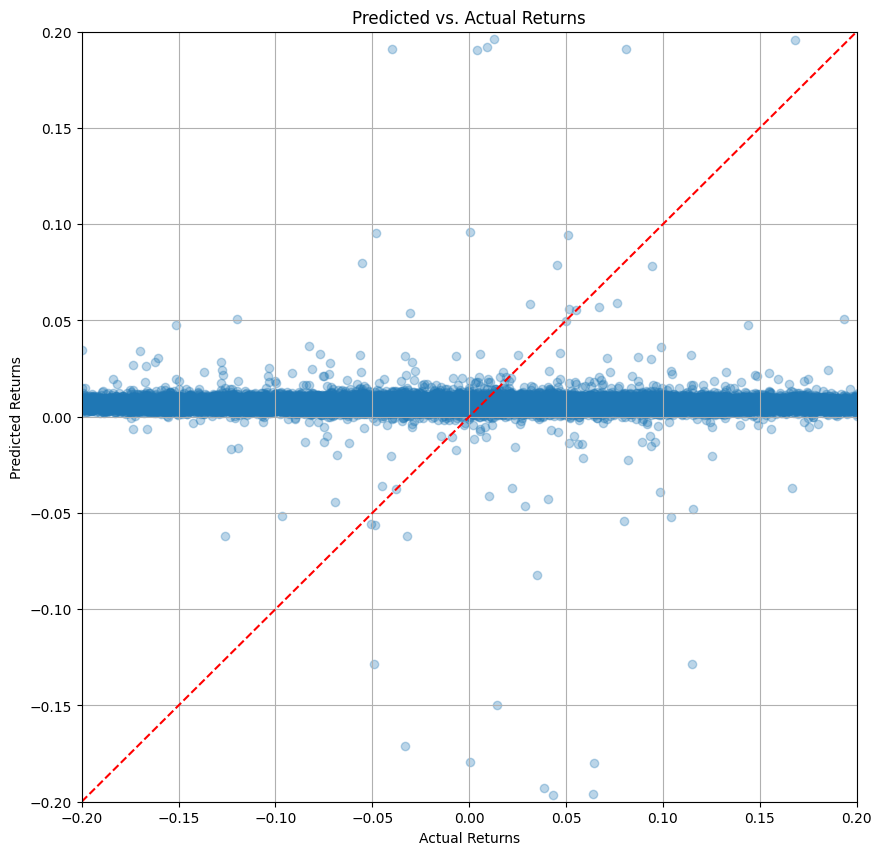

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predicted_returns, alpha=0.3)
plt.plot([-0.2, 0.2], [-0.2, 0.2], color='red', linestyle='--')
plt.title('Predicted vs. Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid(True)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.show()